1

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

3.8.0


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Подготовка

In [4]:
data = pd.read_csv('lenta_40k.csv.zip')

In [5]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [12]:
MAX_LEN = max(len(x) for x in X)

In [13]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [14]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [15]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

## Callbacks

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

## Обучение сети

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
drop1 = keras.layers.Dropout(0.3)(embeddings)

convs = []
for ks in [3, 5, 7, 10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding="same", strides=1)(drop1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding="same", strides=1,
                                  kernel_regularizer="l2", activation="relu")(conv1)
    conv3 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding="same", strides=1,
                                  kernel_regularizer="l2", activation="relu")(conv1)
    conv4 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding="same", strides=1,
                                  kernel_regularizer="l2", activation="relu")(conv1)
    conv5 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding="same", strides=1,
                                  kernel_regularizer="l2", activation="relu")(conv1)
    pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)
    convs.append(pool)

concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)

drop2 = keras.layers.Dropout(0.5)(conv_global)

flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation="relu")(flatten)
outputs = keras.layers.Dense(len(label2id), activation="softmax")(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")],
              )

In [ ]:
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=2000,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.1600 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 1.1553 - rec@prec: 0.0000e+00 - val_loss: 0.8218 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7466 - rec@prec: 1.3369e-06
Epoch 2: val_rec@prec improved from 0.00000 to 0.00045, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.7438 - rec@prec: 1.2788e-06 - val_loss: 0.5401 - val_rec@prec: 4.5086e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4909 - rec@prec: 0.0146
Epoch 3: val_rec@prec improved from 0.00045 to 0.09739, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.4890 - rec@prec: 0.0152 - val_loss: 0.3512 - val_rec@prec: 0.0974
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3187 - rec@prec: 0.1185
Epoch 4: val_rec@prec improved 

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


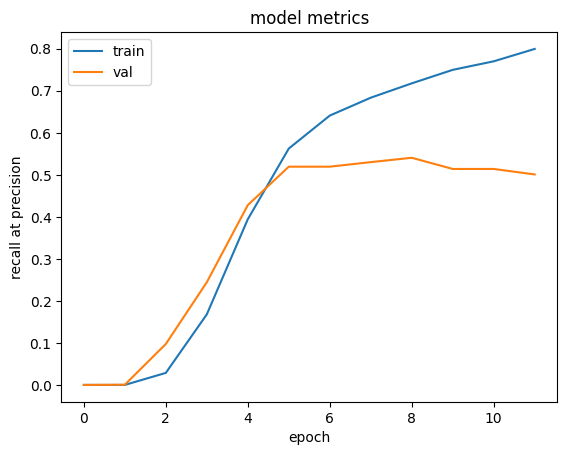

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Нейросеть со сверточными слоями с архитектурой похожей на Unet

In [26]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [29]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

# Encoder
# 1 изменение размерности
conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation='relu')(embeddings)
pool1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

# 2 изменение размерности
conv2 = keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation='relu')(pool1)
pool2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)

# 3 изменение размерности
conv3 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation='relu')(pool2)
pool3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)

# Decoder
# 1 изменение размерности
up1 = keras.layers.UpSampling1D(size=2)(pool3)
conv4 = keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(up1)

# 2 изменение размерности
up2 = keras.layers.UpSampling1D(size=2)(conv4)
conv5 = keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(up2)

# 3 изменение размерности
up3 = keras.layers.UpSampling1D(size=2)(conv5)
conv6 = keras.layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(up3)

# Финальная часть модели
flatten = keras.layers.Flatten()(conv6)
dense1 = keras.layers.Dense(64, activation="relu")(flatten)
dense2 = keras.layers.Dense(64, activation="relu")(dense1)
outputs = keras.layers.Dense(len(label2id), activation="softmax")(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")],)

In [30]:
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=500,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling Conv1D.call().

[1mCUDA out of memory. Tried to allocate 668.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 186.12 MiB is free. Process 12151 has 14.56 GiB memory in use. Of the allocated memory 14.19 GiB is allocated by PyTorch, and 255.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)[0m

Arguments received by Conv1D.call():
  • inputs=torch.Tensor(shape=torch.Size([1000, 1748, 100]), dtype=float32)'

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()